In [1]:
# import useful libraries
import numpy as np
import matplotlib.pyplot as plt

import os
import sys

# add parent directory to sys.path to import STL package modules
PARENT_DIR = os.path.dirname(os.path.abspath(os.getcwd() + "../../../"))
sys.path.append(PARENT_DIR)
print("Parent directory added to sys.path:", ".../" + PARENT_DIR.split("/")[-1])

# test data directory
DATA_TEST_PATH = PARENT_DIR + "/data" + "/test"
print("Dataset dirctory used:", ".../" + PARENT_DIR.split("/")[-1] + DATA_TEST_PATH.split(PARENT_DIR.split("/")[-1])[-1])


from STL_main.STL_2D_Kernel_Torch import STL_2D_Kernel_Torch as DataClass
from STL_main.ST_Operator import ST_Operator as SO
from STL_main.Synthesis import optimize_scattering_LBFGS
import torch

Parent directory added to sys.path: .../STL-Dev
Dataset dirctory used: .../STL-Dev/data/test


In [2]:
# command to auto-reload modules when they are edited (easier for testing and debugging)
%load_ext autoreload
%autoreload 2

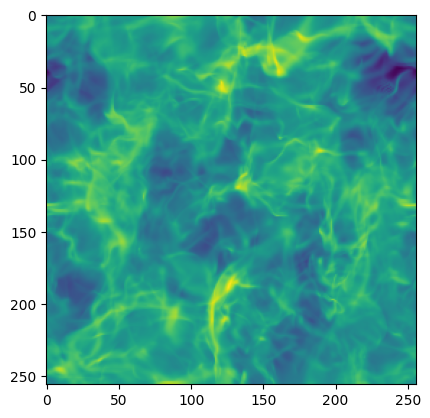

In [3]:
im=np.load(DATA_TEST_PATH + "/" + 'Turb_6.npy')[:,None,:,:]
data=DataClass(im)
plt.imshow(im[0,0])

# test wavelet computation

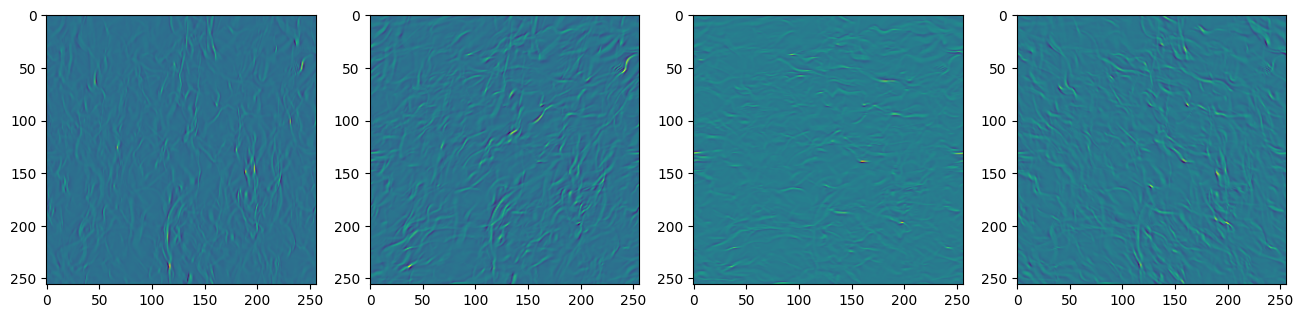

In [5]:
w_op = data.get_wavelet_op()

w_data = w_op.apply(data,0).array

plt.figure(figsize=(16,6))
for k in range(4):
    plt.subplot(1,4,1+k)
    plt.imshow(w_data[0,0,k].cpu().numpy().real)

tensor(20.3149, dtype=torch.float64)


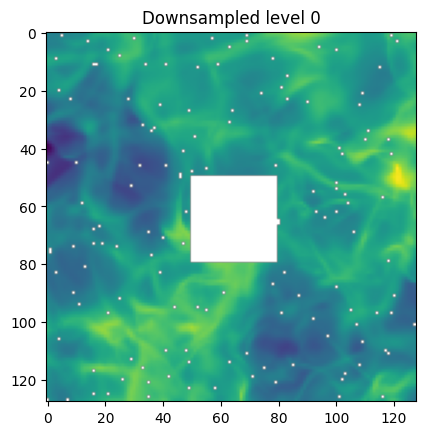

tensor(20.3151, dtype=torch.float64)


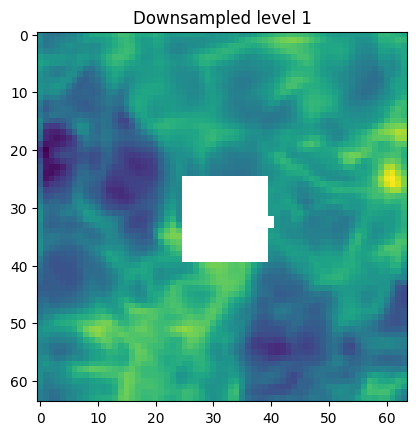

tensor(20.3157, dtype=torch.float64)


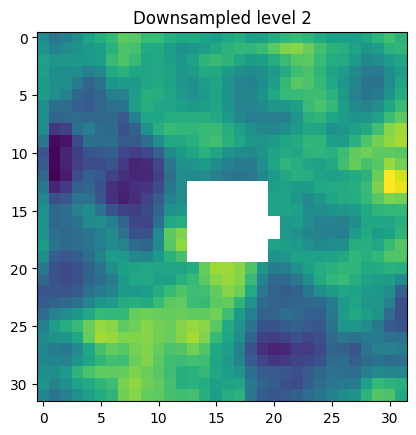

tensor(20.3165, dtype=torch.float64)


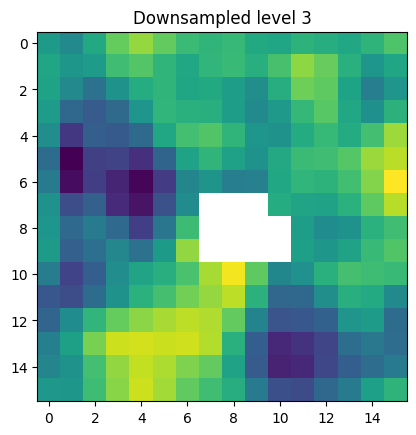

tensor(20.3171, dtype=torch.float64)


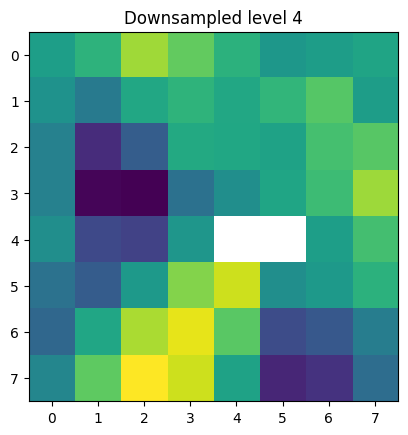

In [29]:
tmp = im[0,0].copy()
np.random.seed(32)
tmp[(np.random.rand(600)*tmp.shape[0]).astype('int'),
    (np.random.rand(600)*tmp.shape[0]).astype('int')]=np.nan
tmp[50:80,50:80] = np.nan

l_data=DataClass(tmp[:128,:128])
w_op = l_data.get_wavelet_op(downsample_nan_weight_threshold=0.33)

for dg in range(5):
    print(torch.nanmean(w_op.downsample(l_data, dg_out=dg, inplace=False).array))
    plt.imshow(w_op.downsample(l_data, dg_out=dg, inplace=False).array)
    plt.title("Downsampled level "+str(dg))
    plt.show()

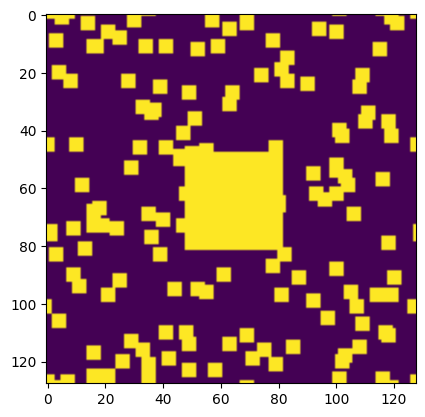

In [31]:
plt.imshow(w_op._mask_full_res_wav_conv.array[2])

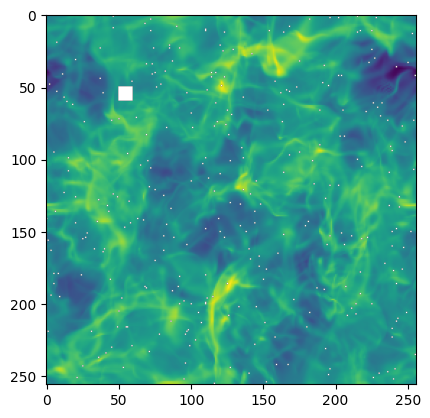

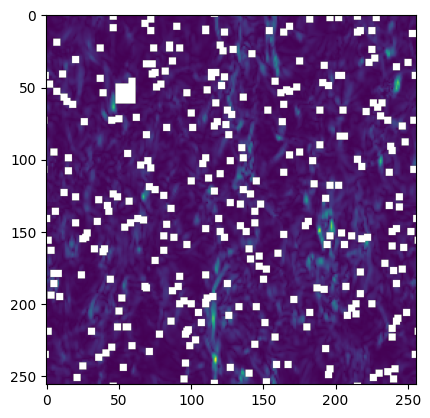

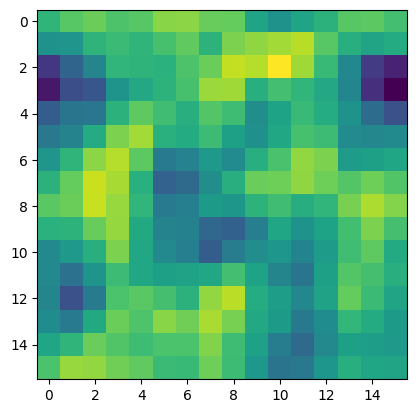

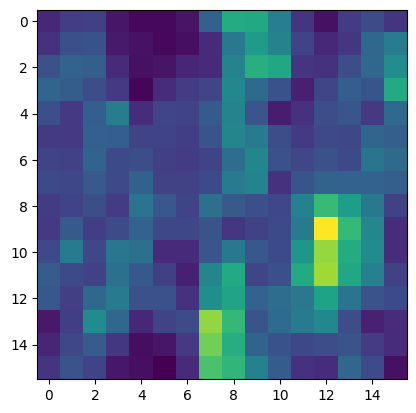

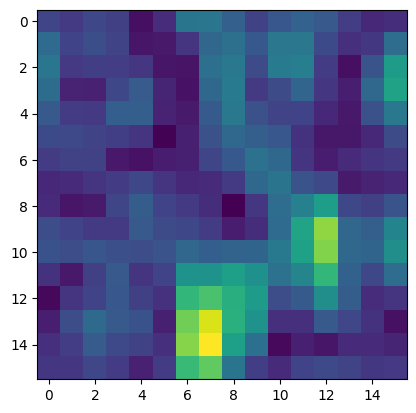

(<matplotlib.image.AxesImage at 0x28f6c3cd0>, None)

In [68]:
tmp = im[0,0].copy()
np.random.seed(32)
tmp[(np.random.rand(300)*tmp.shape[0]).astype('int'),
    (np.random.rand(300)*tmp.shape[0]).astype('int')] = np.nan
tmp[50:60,50:60] = np.nan

plt.imshow(tmp), plt.show()

l_data = DataClass(tmp)
w_op = l_data.get_wavelet_op(downsample_nan_weight_threshold=0.5)


w_data = w_op.apply(l_data, j=0)
plt.imshow(w_data[0].modulus(inplace=False).array.cpu().numpy()), plt.show()


j = 4

plt.imshow(w_op.downsample(l_data, dg_out=j, inplace=False, is_wav_convolved=False).modulus(inplace=False).array.cpu().numpy()), plt.show()


w_data = w_op.downsample(w_data.modulus(inplace=False), dg_out=j, inplace=True, is_wav_convolved=True)
plt.imshow(w_data[0].modulus().array.cpu().numpy()), plt.show()

w_data = w_op.apply(w_data,j=j)
plt.imshow(w_data[0,0].modulus().array.cpu().numpy()), plt.show()

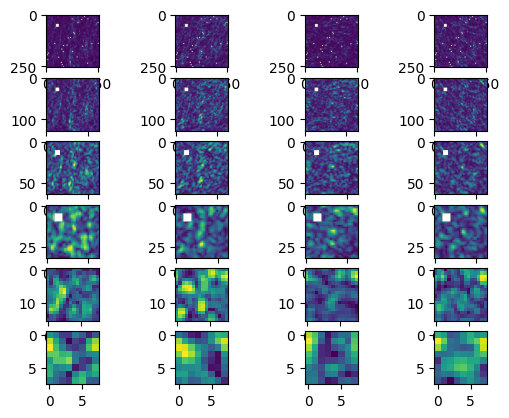

In [92]:
tmp = im[0,0].copy()
np.random.seed(32)
tmp[(np.random.rand(30)*tmp.shape[0]).astype('int'),
    (np.random.rand(30)*tmp.shape[0]).astype('int')] = np.nan
tmp[50:60,50:60] = np.nan

l_data = DataClass(tmp)
w_op = l_data.get_wavelet_op(downsample_nan_weight_threshold=0.33)


for j in range(w_op.J):
    w_data = w_op.apply(l_data,j)
    for k in range(w_op.L):
        plt.subplot(w_op.J,w_op.L,1+k+w_op.L*j)
        plt.imshow(w_data[k].modulus().array.cpu().numpy())
        
    w_op.downsample(l_data, j+1, inplace=True, is_wav_convolved=False) if j < w_op.J-1 else None

In [76]:
from STL_main.ST_Operator import ST_Operator as STO

l_data = DataClass(im[0,0])
l_data_nan = DataClass(tmp)

st_op = STO(l_data)
st_op_nan = STO(DataClass(tmp), downsample_nan_weight_threshold=0.99)

st_data = st_op.apply(l_data)
st_data_nan = st_op_nan.apply(l_data_nan)

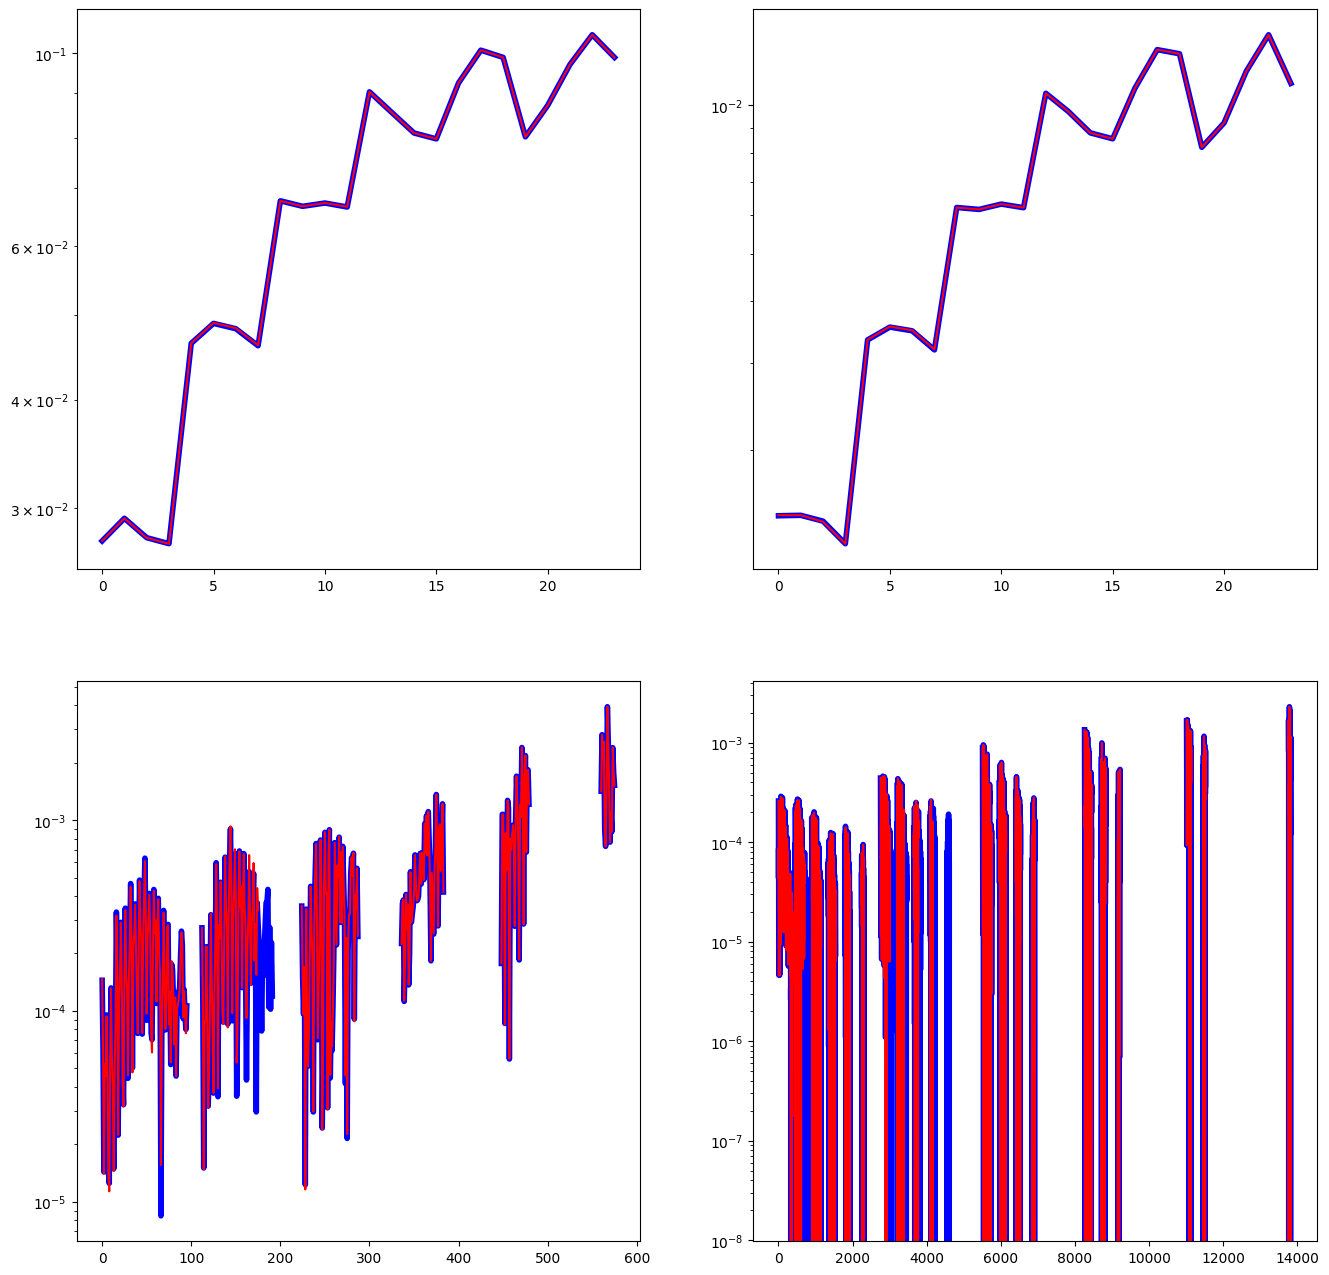

In [77]:
plt.figure(figsize=(16,16))
plt.subplot(2,2,1)
plt.plot(st_data.S1.cpu().numpy().flatten(),color='b',lw=4)
plt.plot(st_data_nan.S1.cpu().numpy().flatten(),color='r')
plt.yscale('log')
plt.subplot(2,2,2)
plt.plot(st_data.S2.cpu().numpy().flatten(),color='b',lw=4)
plt.plot(st_data_nan.S2.cpu().numpy().flatten(),color='r')
plt.yscale('log')


plt.subplot(2,2,3)
plt.plot(st_data.S3.abs().cpu().numpy().flatten(),color='b',lw=4)
plt.plot(st_data_nan.S3.abs().cpu().numpy().flatten(),color='r')
plt.yscale('log')
plt.subplot(2,2,4)
plt.plot(st_data.S4.cpu().numpy().flatten(),color='b',lw=4)
plt.plot(st_data_nan.S4.cpu().numpy().flatten(),color='r')
plt.yscale('log')

# normalization

In [10]:
st_data = st_op.apply(l_data)
st_data_norm = st_op.apply(l_data, norm='store_ref')

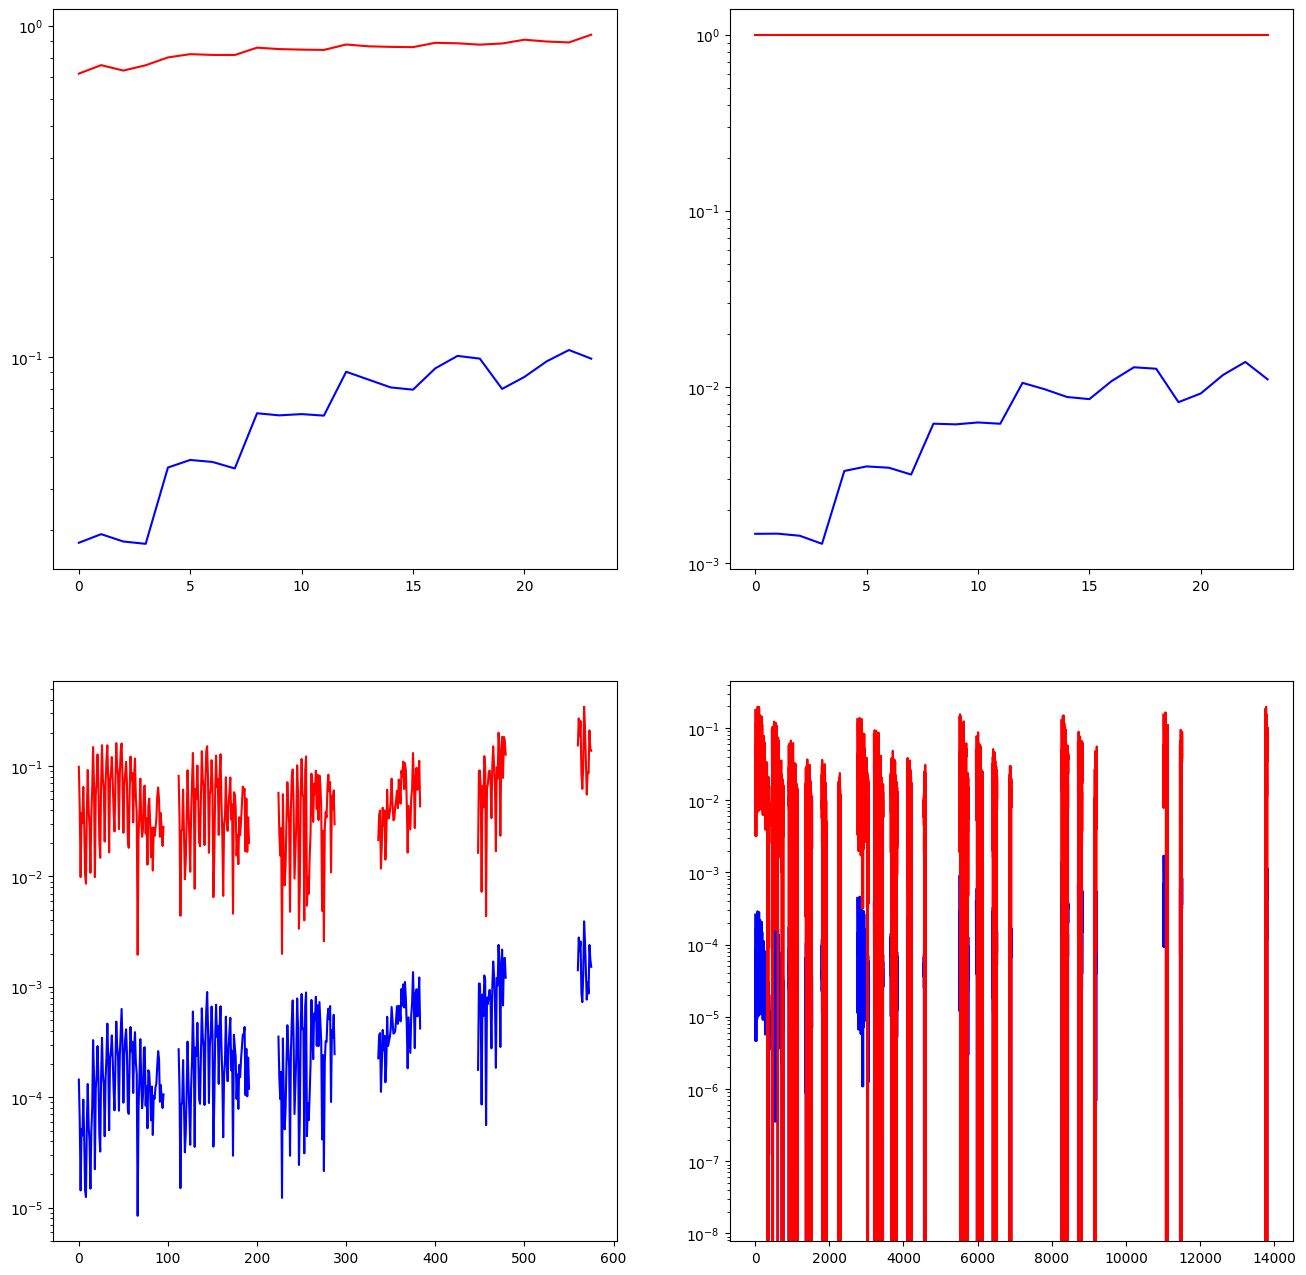

In [11]:
plt.figure(figsize=(16,16))
plt.subplot(2,2,1)
plt.plot(st_data.S1.cpu().numpy().flatten(),color='b')
plt.plot(st_data_norm.S1.cpu().numpy().flatten(),color='r')
plt.yscale('log')
plt.subplot(2,2,2)
plt.plot(st_data.S2.cpu().numpy().flatten(),color='b')
plt.plot(st_data_norm.S2.cpu().numpy().flatten(),color='r')
plt.yscale('log')

plt.subplot(2,2,3)
plt.plot(st_data.S3.abs().cpu().numpy().flatten(),color='b')
plt.plot(st_data_norm.S3.abs().cpu().numpy().flatten(),color='r')
plt.yscale('log')
plt.subplot(2,2,4)
plt.plot(st_data.S4.cpu().numpy().flatten(),color='b')
plt.plot(st_data_norm.S4.cpu().numpy().flatten(),color='r')
plt.yscale('log')

# do synthesis

In [16]:
torch.zeros(2,2) * torch.nan

tensor([[nan, nan],
        [nan, nan]])

In [81]:
u, histo = optimize_scattering_LBFGS(
        im[0,0],
        DataClass,
        SO,
        nbatch=1,
        max_iter=50,
        lr=1.0,
        history_size=50,
        print_iter=10,
        verbose=True,
    )

r: torch.Size([3968]) 0 NaNs
s: torch.Size([3968]) 0 NaNs
s: torch.Size([3968]) 0 NaNs
s: torch.Size([3968]) 0 NaNs
s: torch.Size([3968]) 0 NaNs
s: torch.Size([3968]) 0 NaNs
s: torch.Size([3968]) 0 NaNs


TypeError: Invalid shape (256,) for image data

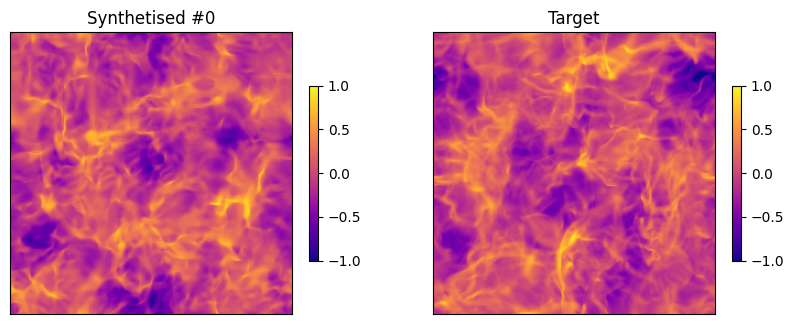

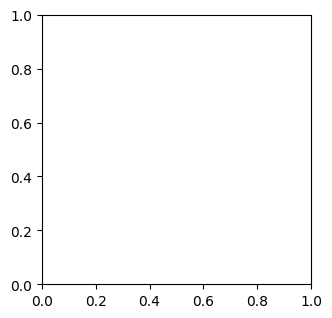

In [ ]:
plt.figure(figsize=(10,10))
amp = 1
plt.subplot(2,2,1)
plt.imshow(u[0].cpu().numpy(), cmap='plasma', vmin=-amp, vmax=amp)
plt.colorbar(shrink=0.5)
plt.xticks([])
plt.yticks([])
plt.title('Synthetised #0')
plt.subplot(2,2,2)
plt.imshow(im[0,0]-np.nanmean(im[0,0]), cmap='plasma', vmin=-amp, vmax=amp)
plt.colorbar(shrink=0.5)
plt.xticks([])
plt.yticks([])
plt.title('Target')

plt.figure(figsize=(16,4))
for k in range(4):
    plt.subplot(1,4,1+k)
    plt.imshow(u[k].cpu().numpy(), cmap='plasma', vmin=-amp, vmax=amp)
    plt.colorbar(shrink=0.5)
    plt.xticks([])
    plt.yticks([])
    plt.title('Synthetised #%d'%(k))

In [101]:
u, histo = optimize_scattering_LBFGS(
        tmp,
        DataClass,
        st_op_target=SO(DataClass(tmp)),
        st_op_running=SO(DataClass(im[0,0])),
        nbatch=1,
        max_iter=50,
        lr=1.0,
        history_size=50,
        print_iter=10,
        verbose=True,
    )

NaN detected in the target, the synthesis takes it into account
[LBFGS] inner iter 10, loss = 1.880345e+04
[LBFGS] inner iter 20, loss = 1.250959e+01
[LBFGS] inner iter 30, loss = 1.390793e+00
[LBFGS] inner iter 40, loss = 5.178289e-01
[LBFGS] inner iter 50, loss = 2.867604e-01


TypeError: Invalid shape (256,) for image data

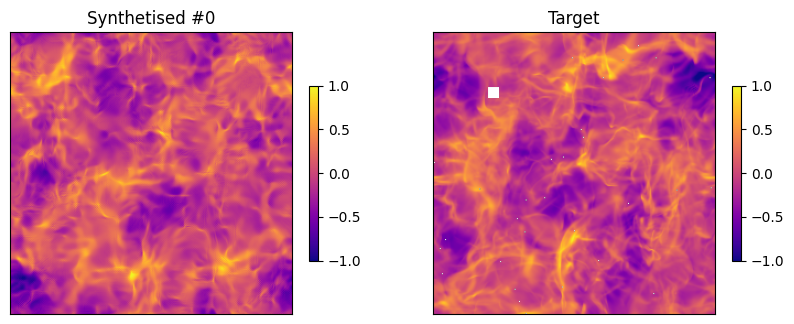

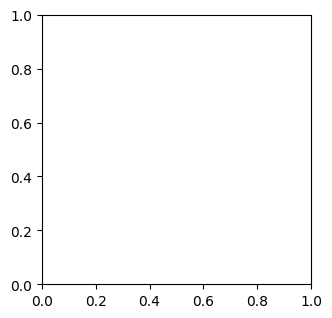

In [105]:
plt.figure(figsize=(10,10))
amp = 1
plt.subplot(2,2,1)
plt.imshow(u.cpu().numpy(), cmap='plasma', vmin=-amp, vmax=amp)
plt.colorbar(shrink=0.5)
plt.xticks([])
plt.yticks([])
plt.title('Synthetised #0')
plt.subplot(2,2,2)
plt.imshow(tmp-np.nanmean(tmp), cmap='plasma', vmin=-amp, vmax=amp)
plt.colorbar(shrink=0.5)
plt.xticks([])
plt.yticks([])
plt.title('Target')

plt.figure(figsize=(16,4))
for k in range(4):
    plt.subplot(1,4,1+k)
    plt.imshow(u[k].cpu().numpy(), cmap='plasma', vmin=-amp, vmax=amp)
    plt.colorbar(shrink=0.5)
    plt.xticks([])
    plt.yticks([])
    plt.title('Synthetised #%d'%(k))